# focus | attention | confusion | effort

### Problem Statement:

Can a reliable model be built that measures an individual's brain waves and pupil dilation in order to explore effort, attention, focus, and struggle. By averaging this model’s predictions, can a metric of learning provide a reliable correlation to real life performance.

### Overview:

The electroencephalogram (EEG) is widely viewed as the least intrusive window into the human mind.  By taking the measurements of brain activity (microvolts), neuroscientists have been able to pinpoint specific physiological reactions to stimuli.  Event related potentials (ERP)'s are the most studied as they produce easy to interpret peaks and troughs a reliable amount of time after a stimulus.  However, there is far less published research on the process of learning within the mind.  While experts have long pinpointed Beta waves as an rough indicator of focus and attention, more recent research has identified higher frequency gamma waves as an indicator of consciousness.  However, the unavoidable challenge with interpreting gamma waves is that they oscillate in the brain at the some frequencies as muscle movement.  With this basic understanding under my belt I have attempted to take some steps towards personally understanding the challenges, and contribute to the cause of understanding the process of learning.  

### Methodology:
Given the overwhelming challenge that was in front of me, it was important to start with designing an well thought out methodology to tackle this challenge.  Though I was planning ambitious experiment, I still needed to limit some of the variables.  The easy choice for feasibility was to limit the data collection to one participant -- myself.  

#### EEG Collection:
I collected brainwave information by using the Muse EEG headband, the Muse Monitor iphone app to stream the data directly into a .csv and then processed the data with a handful of data cleaning Python scripts.  Much care was given to collecting markers to signify different activities during the data collection process, and therefore, it was essential to then convert all data collected into the same common time format, Pandas DateTime.

For this initial "Simple" Model, I am attempting to classify piano performances as either "learned" or "learning".  For the "learned" training data, I played a series of piano pieces that I know fairly well while collecting my EEG data.   For the "learning" training data I sight read (and struggled through) never before seen music.  After recording, the data was then processed using Fast Fourier Transformation (FFT) to pull out individual frequency ranges and amplitudes.  


#### Pupil Dilation:
I collected pupil measurements using a headset from Pupil Labs.  After painstaking setup of having to manipulate the headset to fit on top of the EEG headband, and still angled to observe my pupil measurements I ultimately was able to collect usable data, along with the corresponding time stamps to the align with the EEG data, after processing it into Pandas DateTime.  However, much of the data was lost to head movement, so ultimately this process still needs to be refined if pupil data is to contribute to a final model.  Given the questionable measurements, I found it best to use percent change in pupil dilation instead of absolute pupil size.  

#### Audio Recording:
Lastly, I collected audio data in order to correspond with the collected EEG data.  While not directly involved with this initial study, after some initial hurdles to building a Python audio recorder that also collects corresponding start and stop time stamps, it is not much harder to collect the audio in addition to the first data types.  Ultimately, it will be fun to align brain waves with arrays of audio vectors and build some interesting applications from them.  

#### Combining Data:
Even though the simple model only uses the EEG data, a scalable pipeline was built in Python to read .csv files from various directories, combine the data types, filter out unusable information, and preprocess it for modeling with a Standard Scaler. Audio arrays were resized to correspond with a given row of audio data.

### Modeling:
The data is was then run through a series of Linear and Tree based models in Scikit Learn. 

In [150]:
import pandas as pd
import numpy as np
from scipy.io import wavfile
import matplotlib.pyplot as plt
import seaborn as sns

import datetime
import time
import os

pd.options.display.max_columns = None
pd.options.display.max_rows = None

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [113]:
from muselsl import stream, list_muses, view, record

# Search for available Muse devices
#muses = list_muses()

In [18]:
learned1 = pd.read_csv('./data/eeg/Learn_No_Learn/museMonitor_Learned.csv')
learned2 = pd.read_csv('./data/eeg/Learn_No_Learn/museMonitor_Learned_2.csv')
learned3 = pd.read_csv('./data/eeg/2019_08_23_am/museMonitor_2019-08-23--08-46-24.csv')

learned = pd.concat([learned1, learned2])
learned = pd.concat([learned, learned3])

#### Specific Pieces

In [19]:
mixed = pd.read_csv('./data/eeg/Learn_No_Learn/museMonitor_2019-08-26--09-06-33.csv')
mixed[mixed["Elements"] == '/Marker/1'].index

Int64Index([37181, 159670, 253963], dtype='int64')

In [20]:
learned_Hedwig = mixed[:37181]
learned_Arabesque = mixed[159671:253963]

#Save for testing
learning_Nocturne = mixed[37182:159670]
learning_Mazurkas = mixed[253964:]

In [21]:
#Combine 'Learned' with the sample from the mixed recording

learned = pd.concat([learned, learned_Hedwig])
learned = pd.concat([learned, learned_Arabesque])

#### Multiple Takes

In [22]:
take_1 = pd.read_csv('./data/eeg/Learn_No_Learn/museMonitor_2019-08-26--17-41-25.csv')
take_2 = pd.read_csv('./data/eeg/Learn_No_Learn/museMonitor_2019-08-26--18-01-57.csv')
take_3 = pd.read_csv('./data/eeg/Learn_No_Learn/museMonitor_2019-08-26--18-23-35.csv')
take_4 = pd.read_csv('./data/eeg/Learn_No_Learn/museMonitor_2019-08-26--18-24-42.csv')

#### Learning Data

In [23]:
learning1 = pd.read_csv('./data/eeg/Learn_No_Learn/museMonitor_Learning.csv')
learning2 = pd.read_csv('./data/eeg/Learn_No_Learn/museMonitor_Learning_2.csv')

learning = pd.concat([learning1, learning2])
learning = pd.concat([learning, take_1])
learning = pd.concat([learning, take_2])
#learning = pd.concat([learning, learning_Mazurkas])
#learning = pd.concat([learning, learning_Mazurkas])

In [24]:
learned['learned'] = 1
learning['learned'] = 0

In [25]:
df = pd.concat([learned, learning])

In [26]:
df.shape

(1625604, 40)

In [27]:
df.columns

Index(['TimeStamp', 'Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10',
       'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9',
       'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 'Beta_TP9', 'Beta_AF7',
       'Beta_AF8', 'Beta_TP10', 'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8',
       'Gamma_TP10', 'RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10', 'AUX_RIGHT',
       'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z', 'Gyro_X',
       'Gyro_Y', 'Gyro_Z', 'HeadBandOn', 'HSI_TP9', 'HSI_AF7', 'HSI_AF8',
       'HSI_TP10', 'Battery', 'Elements', 'learned'],
      dtype='object')

In [28]:
columns = ['TimeStamp', 'Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10',
       'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9',
       'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 'Beta_TP9', 'Beta_AF7',
       'Beta_AF8', 'Beta_TP10', 'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8',
       'Gamma_TP10', 'RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10', 'learned']

In [29]:
#Keep only rows where the sensor contact is good
df = df[(df['HSI_AF7'] == 1.0) & (df['HSI_AF8'] == 1.0) & (df['HSI_TP9'] == 1.0) & (df['HSI_TP10'] == 1.0)]


In [30]:
df.shape

(1430585, 40)

In [31]:
df=df[columns]

In [32]:
df['Theta'] = df[['Theta_TP9','Theta_TP10','Theta_AF7', 'Theta_AF8']].mean(axis=1)
df['Alpha'] = df[['Alpha_TP9','Alpha_TP10','Alpha_AF7', 'Alpha_AF8']].mean(axis=1)
df['Beta'] = df[['Beta_TP9','Beta_TP10','Beta_AF7', 'Beta_AF8']].mean(axis=1)
df['Gamma'] = df[['Gamma_TP9','Gamma_TP10','Gamma_AF7', 'Gamma_AF8']].mean(axis=1)
df['Delta'] = df[['Delta_TP9','Delta_TP10','Delta_AF7', 'Delta_AF8']].mean(axis=1)
df['RAW'] = df[['RAW_TP9','RAW_TP10','RAW_AF7', 'RAW_AF8']].mean(axis=1)

In [33]:
df['ThetaBeta'] = df['Theta'] / df['Beta']
df['ThetaAlpha'] = df['Theta'] / df['Alpha']
df['GammaSquare'] = np.exp(df['Gamma'])

In [34]:
df['learned'].value_counts(normalize=True)

0    0.50031
1    0.49969
Name: learned, dtype: float64

### TimeStamp

In [35]:
df["TimeStamp"] = pd.to_datetime(df["TimeStamp"])
#eeg_df.set_index('TimeStamp', inplace=True)
#eeg_df.sort_index(inplace=True)

### Model Preprocessing

In [36]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [37]:
df.head()

,TimeStamp,Delta_TP9,Delta_AF7,Delta_AF8,Delta_TP10,Theta_TP9,Theta_AF7,Theta_AF8,Theta_TP10,Alpha_TP9,Alpha_AF7,Alpha_AF8,Alpha_TP10,Beta_TP9,Beta_AF7,Beta_AF8,Beta_TP10,Gamma_TP9,Gamma_AF7,Gamma_AF8,Gamma_TP10,RAW_TP9,RAW_AF7,RAW_AF8,RAW_TP10,learned,Theta,Alpha,Beta,Gamma,Delta,RAW,ThetaBeta,ThetaAlpha,GammaSquare
0,2019-08-24 15:15:43.828,1.182725,1.133356,1.11819,1.554511,0.795756,0.662566,0.750052,1.168452,0.950028,0.81534,0.56519,1.160695,0.881148,-0.026229,-0.144272,0.249599,0.812886,-0.560242,-0.712694,-0.498451,774.835165,853.003663,861.868132,842.930403,1,0.844206,0.872813,0.240061,-0.239625,1.247196,833.159341,3.516626,0.967224,0.786923
1,2019-08-24 15:15:43.829,1.182725,1.133356,1.11819,1.554511,0.795756,0.662566,0.750052,1.168452,0.950028,0.81534,0.56519,1.160695,0.881148,-0.026229,-0.144272,0.249599,0.812886,-0.560242,-0.712694,-0.498451,777.655678,850.183150,859.047619,845.347985,1,0.844206,0.872813,0.240061,-0.239625,1.247196,833.058608,3.516626,0.967224,0.786923
2,2019-08-24 15:15:43.829,1.182725,1.133356,1.11819,1.554511,0.795756,0.662566,0.750052,1.168452,0.950028,0.81534,0.56519,1.160695,0.881148,-0.026229,-0.144272,0.249599,0.812886,-0.560242,-0.712694,-0.498451,781.684982,846.153846,859.047619,846.959707,1,0.844206,0.872813,0.240061,-0.239625,1.247196,833.461538,3.516626,0.967224,0.786923
3,2019-08-24 15:15:43.829,1.182725,1.133356,1.11819,1.554511,0.795756,0.662566,0.750052,1.168452,0.950028,0.81534,0.56519,1.160695,0.881148,-0.026229,-0.144272,0.249599,0.812886,-0.560242,-0.712694,-0.498451,788.534799,844.945055,859.450549,842.527473,1,0.844206,0.872813,0.240061,-0.239625,1.247196,833.864469,3.516626,0.967224,0.786923
4,2019-08-24 15:15:43.829,1.182725,1.133356,1.11819,1.554511,0.795756,0.662566,0.750052,1.168452,0.950028,0.81534,0.56519,1.160695,0.881148,-0.026229,-0.144272,0.249599,0.812886,-0.560242,-0.712694,-0.498451,788.937729,845.347985,857.435897,839.706960,1,0.844206,0.872813,0.240061,-0.239625,1.247196,832.857143,3.516626,0.967224,0.786923


In [38]:
X = df.drop(['TimeStamp', 'learned'], axis=1)
y = df['learned']

In [39]:
#X = df[['RAW_TP9','RAW_TP10','RAW_AF7','RAW_AF8']]
#X = df[['Gamma_AF7']]

In [ ]:
y = np.random.randint(2, size=len(X))

In [40]:
X_train, X_val, y_train, y_val = train_test_split(X, y)

In [41]:
ss = StandardScaler()

In [42]:
X_train_sc = ss.fit_transform(X_train)
X_val_sc = ss.transform(X_val)

### Baseline Model

In [43]:
y.value_counts(normalize=True)

0    0.50031
1    0.49969
Name: learned, dtype: float64

### Linear Models

In [44]:
from sklearn.linear_model import RidgeClassifierCV, RidgeCV, LinearRegression
from sklearn.linear_model import LassoCV, LogisticRegressionCV
from sklearn.naive_bayes import GaussianNB, MultinomialNB
import xgboost as xgb

In [45]:
#RidgeClassifierCV
RC = RidgeClassifierCV()
RC.fit(X_train_sc, y_train)
print(f'Ridge (training): {RC.score(X_train_sc, y_train)}')
print(f'Ridge (testing): {RC.score(X_val_sc, y_val)}')

Ridge (training): 0.8986483841564005
Ridge (testing): 0.8975693910475973


In [46]:
#GaussianNB
GNB = GaussianNB()
GNB.fit(X_train_sc, y_train)
print(f'GaussianNB (training): {GNB.score(X_train_sc, y_train)}')
print(f'GaussianNB (testing): {GNB.score(X_val_sc, y_val)}')

GaussianNB (training): 0.865015499497641
GaussianNB (testing): 0.8640447144810386


In [47]:
#LassoCV
Lasso = LassoCV()
Lasso.fit(X_train_sc, y_train)
print(f'Lasso (training): {Lasso.score(X_train_sc, y_train)}')
print(f'Lasso (testing): {Lasso.score(X_val_sc, y_val)}')

Lasso (training): 0.6222027181194463
Lasso (testing): 0.6196313967669556


In [48]:
LR = LogisticRegressionCV()
LR.fit(X_train_sc, y_train)
print(f'Logistic Regression (training): {LR.score(X_train_sc, y_train)}')
print(f'Logistic Regression (testing): {LR.score(X_val_sc, y_val)}')

Logistic Regression (training): 0.8988711370088486
Logistic Regression (testing): 0.8977315621269016


In [165]:
#Create a coefficient dataframe from the feature columns and the coefficients.  Transposed to be in column form.
coefficients = pd.concat([pd.DataFrame(X_val.columns),pd.DataFrame(np.transpose(np.abs(LR.coef_)))], axis = 1)
coefficients['Feature']=coefficients.iloc[:,0]
coefficients['Coefficient']=np.exp(coefficients.iloc[:,1])
coefficients.drop(0, inplace= True, axis=1)
coefficients.sort_values('Coefficient', ascending=False).head(10)

,Feature,Coefficient
17,Gamma_AF7,4.556098
18,Gamma_AF8,3.027459
1,Delta_AF7,2.625653
27,Gamma,2.476368
2,Delta_AF8,2.079200
16,Gamma_TP9,2.078703
5,Theta_AF7,1.791894
32,GammaSquare,1.675961
14,Beta_AF8,1.496944
3,Delta_TP10,1.338421


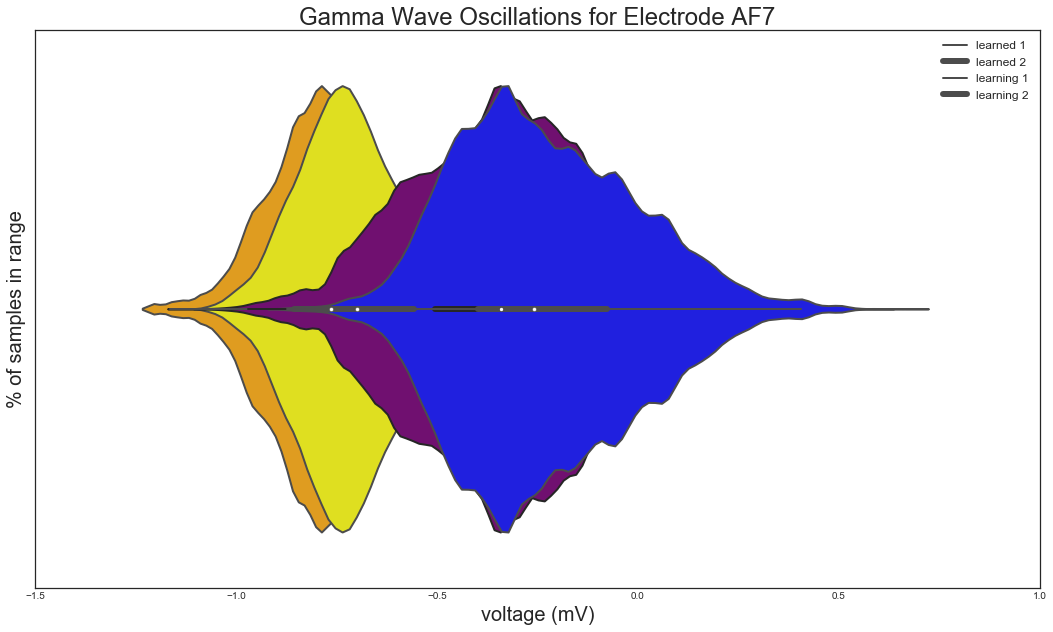

In [164]:
fig = plt.figure(figsize=(18,10))

plt.subplot = sns.violinplot(learned1['Gamma_AF7'], color='orange', label='learned 1')
plt.subplot = sns.violinplot(learned2['Gamma_AF7'], color='yellow', label='learned 2')

plt.subplot = sns.violinplot(learning1['Gamma_AF7'], color='purple', label='learning 1')
plt.subplot = sns.violinplot(learning2['Gamma_AF7'], color='blue', label='learning 2')

plt.xlabel('voltage (mV)', fontsize=20)
plt.ylabel('% of samples in range', fontsize=20)
plt.title('Gamma Wave Oscillations for Electrode AF7', fontsize=24)

plt.legend(('learned 1', 'learned 2', 'learning 1', 'learning 2'), fontsize=12)

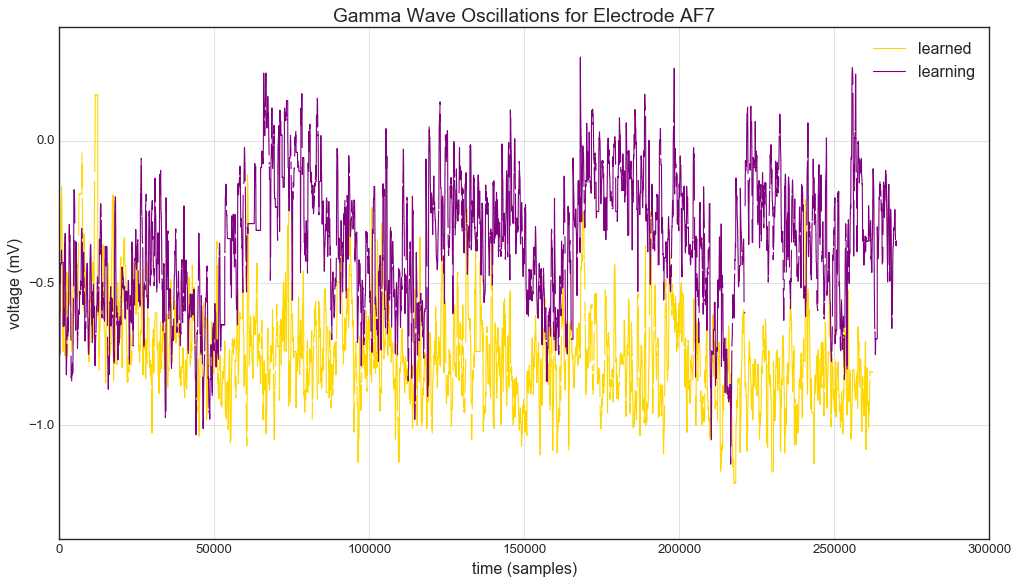

In [146]:
# Setting FiveThirtyEight style
plt.style.use('seaborn-white')

fig = plt.figure(figsize=(15,8))
ax  = fig.add_subplot(111)

ax.plot(learned1['Gamma_AF7'].iloc[:270_000], color='gold', label='learned', linewidth=1.0)
ax.plot(learning1['Gamma_AF7'].iloc[:270_000], color ='purple', label='learning', linewidth=1.0)

plt.xlabel('time (samples)')
plt.ylabel('voltage (mV)')
plt.title('Gamma Wave Oscillations for Electrode AF7')
plt.grid(True)

ax.plot(linewidth=1.0)

leg = plt.legend()


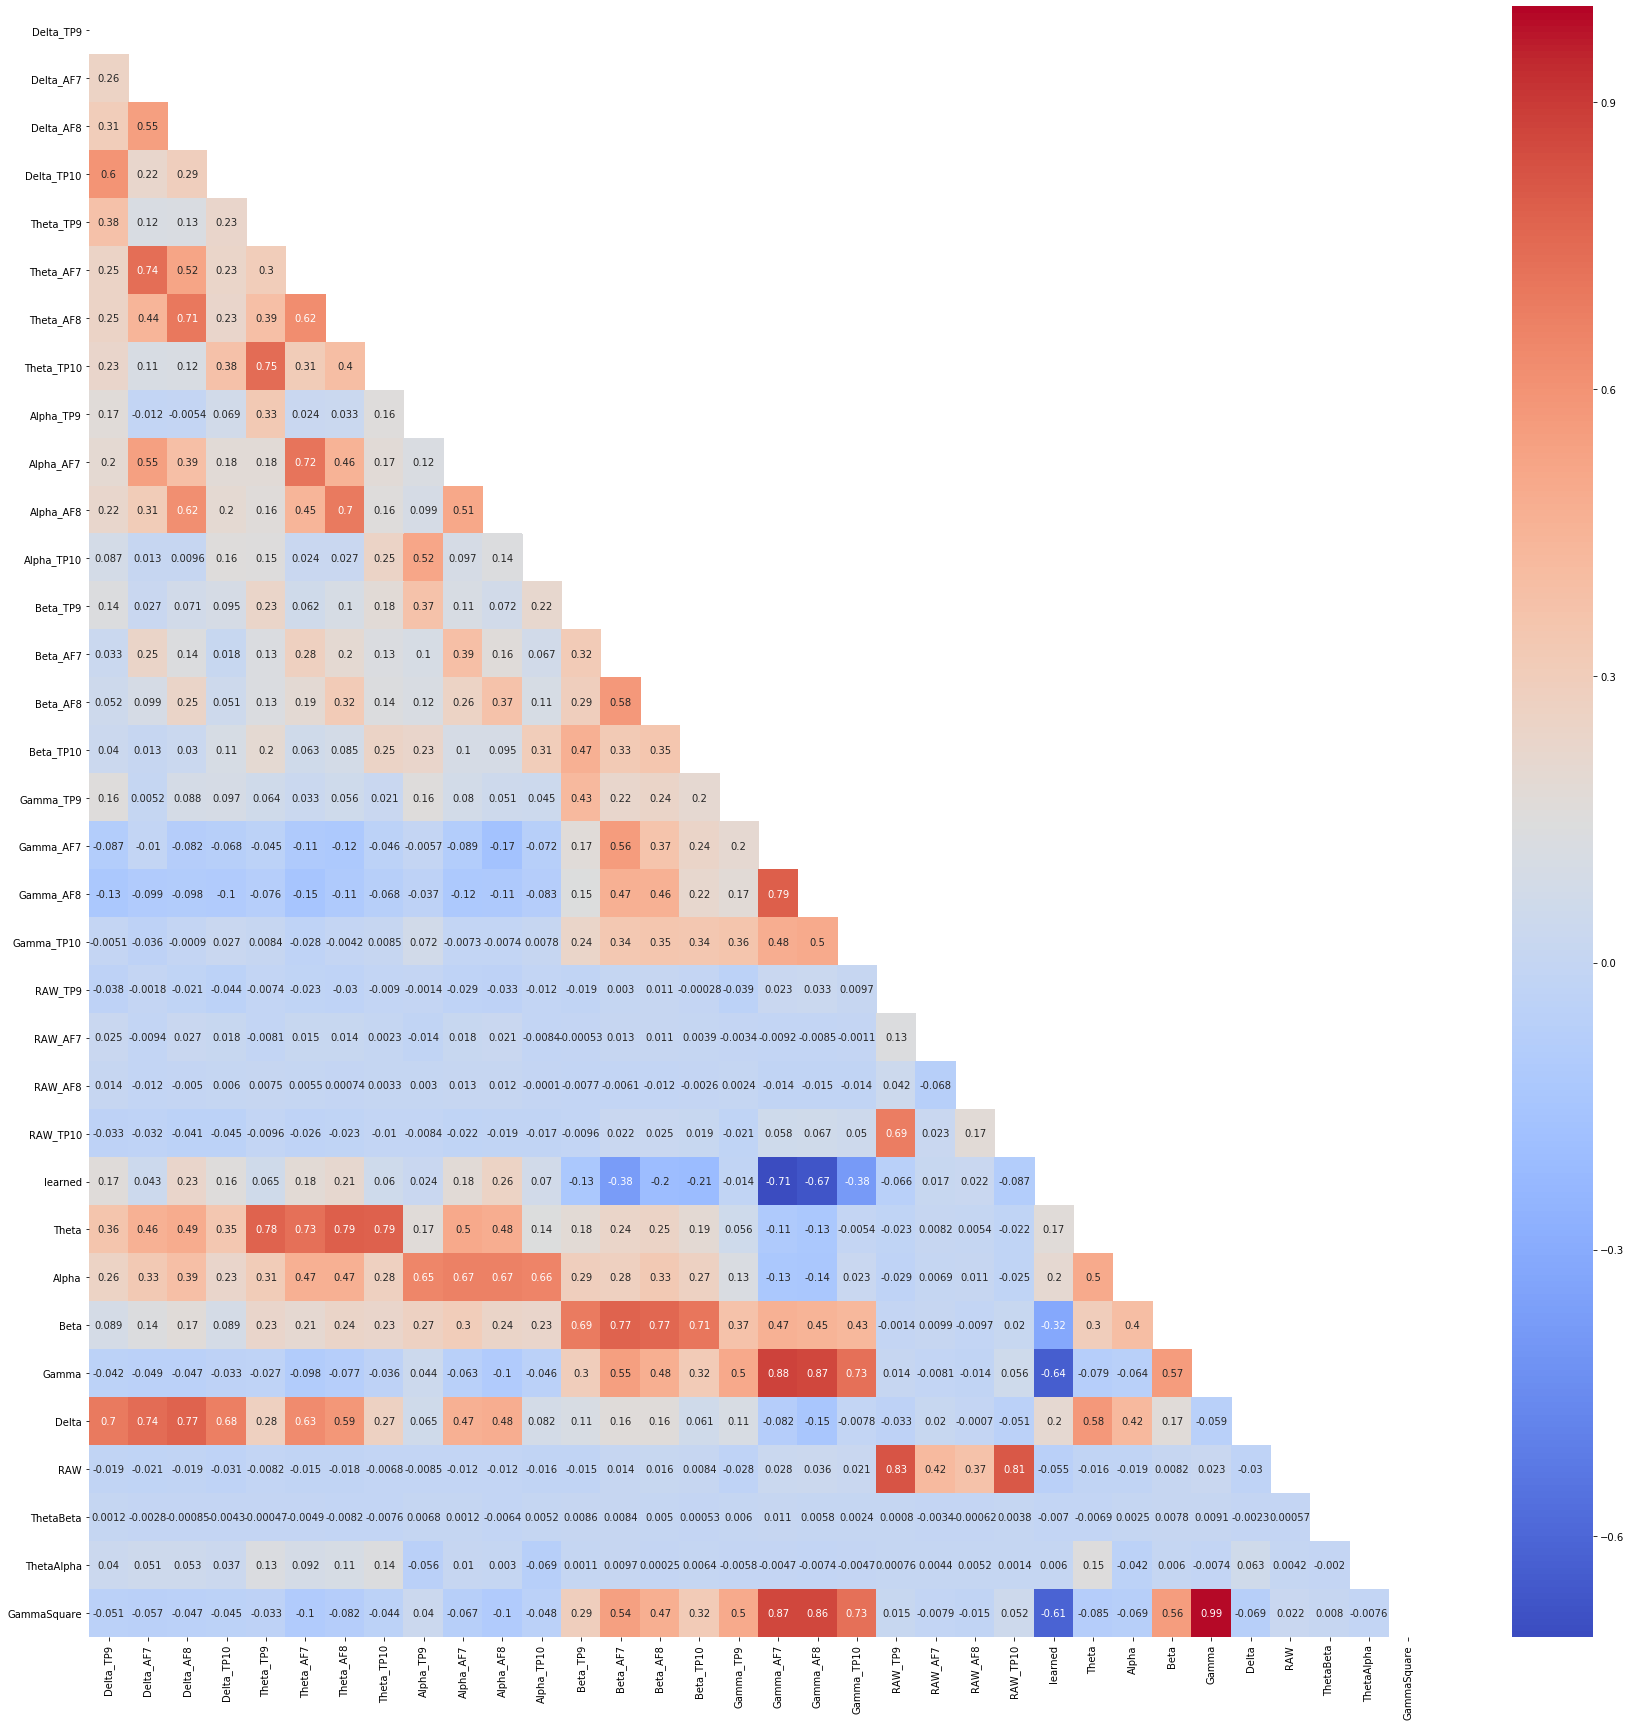

In [57]:
plt.figure(figsize=(30,30))

# Generate a mask for the upper triangle
mask = np.zeros_like(df.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True


sns.heatmap(df.corr(), mask=mask, cmap='coolwarm', annot=True)



## Tree Based Models

In [58]:
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [59]:
#Decision Tree Classifier
DT = DecisionTreeClassifier()
DT.fit(X_train_sc, y_train)
print(f'Decision Tree Classifier (training): {DT.score(X_train_sc, y_train)}')
print(f'Decision Tree Classifer (testing): {DT.score(X_val_sc, y_val)}')
DT_preds = DT.predict(X_val_sc)

Decision Tree Classifier (training): 1.0
Decision Tree Classifer (testing): 0.999969243415994


In [60]:
#Extra Tree Classifier
ET = ExtraTreeClassifier()
ET.fit(X_train_sc, y_train)
print(f'Extra Tree Classifier (training): {ET.score(X_train_sc, y_train)}')
print(f'Extra Tree Classifer (testing): {ET.score(X_val_sc, y_val)}')
ET_preds = ET.predict(X_val_sc)

Extra Tree Classifier (training): 1.0
Extra Tree Classifer (testing): 0.9998937499825247


In [61]:
#Random Forest Tree Classifier
RF = RandomForestClassifier()
RF.fit(X_train_sc, y_train)
print(f'Random Forest Classifier (training): {RF.score(X_train_sc, y_train)}')
print(f'Random Forest Classifer (testing): {RF.score(X_val_sc, y_val)}')
RF_preds = RF.predict(X_val_sc)

Random Forest Classifier (training): 1.0
Random Forest Classifer (testing): 1.0


In [116]:
RF_features = pd.concat([pd.DataFrame(X_val.columns),pd.DataFrame(np.transpose(np.abs(RF.feature_importances_)))], axis = 1)
#Create a coefficient dataframe from the feature columns and the coefficients.  Transposed to be in column form.

RF_features['Feature']=RF_features.iloc[:,0]
RF_features['Coefficient']=RF_features.iloc[:,1]
RF_features.drop(0, inplace= True, axis=1)
RF_features.sort_values('Coefficient', ascending=False).head(10)

,Feature,Coefficient
17,Gamma_AF7,0.253853
18,Gamma_AF8,0.131558
27,Gamma,0.091974
32,GammaSquare,0.073248
16,Gamma_TP9,0.040216
13,Beta_AF7,0.038540
19,Gamma_TP10,0.026747
10,Alpha_AF8,0.026508
2,Delta_AF8,0.023012
26,Beta,0.019800


### Confusion Matrix

In [117]:
#Import packages to print confusion matrices and classification reports to analyze the results
from sklearn.metrics import confusion_matrix, classification_report

conf_mat = confusion_matrix(y_val, DT_preds)
classreport = classification_report(y_val, DT_preds)
                                   #,target_names=['Sanders','Buttigieg','Harris','Warren'], )

In [118]:
conf_mat

array([[178538,      4],
       [     7, 179098]])

In [119]:
print(classreport)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    178542
           1       1.00      1.00      1.00    179105

    accuracy                           1.00    357647
   macro avg       1.00      1.00      1.00    357647
weighted avg       1.00      1.00      1.00    357647



### ROC Curve

In [71]:
from sklearn.metrics import roc_auc_score

In [120]:
X_val.head()

,Delta_TP9,Delta_AF7,Delta_AF8,Delta_TP10,Theta_TP9,Theta_AF7,Theta_AF8,Theta_TP10,Alpha_TP9,Alpha_AF7,Alpha_AF8,Alpha_TP10,Beta_TP9,Beta_AF7,Beta_AF8,Beta_TP10,Gamma_TP9,Gamma_AF7,Gamma_AF8,Gamma_TP10,RAW_TP9,RAW_AF7,RAW_AF8,RAW_TP10,Theta,Alpha,Beta,Gamma,Delta,RAW,ThetaBeta,ThetaAlpha,GammaSquare
241502,0.699363,1.087113,0.934404,0.533461,1.472827,0.917588,0.919961,1.526717,1.014101,1.147648,0.782127,1.158476,0.348616,0.625198,0.297193,0.432898,0.037310,0.277964,-0.332190,-0.046671,827.619048,864.285714,840.109890,836.483516,1.209273,1.025588,0.425976,-0.015897,0.813585,842.124542,2.838829,1.179102,0.984229
248487,0.836429,1.379674,1.267658,0.638480,0.876342,0.696772,0.535099,0.648896,1.080099,0.688557,0.453290,1.066409,0.010779,0.084981,-0.040052,0.181847,-0.465287,-0.195816,-0.183224,-0.337160,840.915751,847.765568,857.032967,844.139194,0.689277,0.822089,0.059389,-0.295372,1.030560,847.463370,11.606173,0.838446,0.744255
169140,0.655785,0.766905,1.031413,0.625196,1.304270,0.424339,1.172733,1.491521,0.639379,0.543601,0.637049,0.451216,0.156852,-0.077232,-0.127991,-0.054361,-0.119206,-0.840863,-0.892683,-0.284321,867.509158,853.406593,871.941392,858.644689,1.098216,0.567811,-0.025683,-0.534268,0.769825,862.875458,-42.760563,1.934120,0.586098
196089,1.607504,1.512454,1.616376,1.050026,0.712819,1.142946,1.157314,0.920175,0.413093,0.866104,0.995513,0.780325,0.245409,0.140830,-0.115711,0.400776,-0.307668,-0.478657,-0.430668,-0.379281,849.377289,882.820513,850.989011,848.974359,0.983313,0.763759,0.167826,-0.399068,1.446590,858.040293,5.859126,1.287466,0.670945
144954,1.506974,1.695593,1.477668,1.216181,1.109017,1.158788,0.967853,0.875361,1.137310,0.720166,0.829563,1.137250,0.423322,-0.110312,-0.285058,0.419423,0.196039,-0.463513,-0.593151,0.261834,854.615385,849.780220,850.183150,857.838828,1.027755,0.956072,0.111844,-0.149698,1.474104,853.104396,9.189211,1.074976,0.860968


In [121]:
roc_auc_score(y_val, ET_preds)

0.9998936792952988

## Testing on New Data

In [122]:
def clean_for_test(df):
    df = df[(df['HSI_AF7'] == 1.0) & (df['HSI_AF8']) & (df['HSI_TP9'] == 1.0) & (df['HSI_TP10'] == 1.0)]
    df = df[columns[:-1]]
    
    df['Theta'] = df[['Theta_TP9','Theta_TP10','Theta_AF7', 'Theta_AF8']].mean(axis=1)
    df['Alpha'] = df[['Alpha_TP9','Alpha_TP10','Alpha_AF7', 'Alpha_AF8']].mean(axis=1)
    df['Beta'] = df[['Beta_TP9','Beta_TP10','Beta_AF7', 'Beta_AF8']].mean(axis=1)
    df['Gamma'] = df[['Gamma_TP9','Gamma_TP10','Gamma_AF7', 'Gamma_AF8']].mean(axis=1)
    df['Delta'] = df[['Delta_TP9','Delta_TP10','Delta_AF7', 'Delta_AF8']].mean(axis=1)
    df['RAW'] = df[['RAW_TP9','RAW_TP10','RAW_AF7', 'RAW_AF8']].mean(axis=1)
    
    df['ThetaBeta'] = df['Theta'] / df['Beta']
    df['ThetaAlpha'] = df['Theta'] / df['Alpha']
    df['GammaSquare'] = np.exp(df['Gamma'])
    
    return df

In [123]:
def prepare_for_test(df):
    df = clean_for_test(df)
    
    df = df.drop('TimeStamp', axis=1)
    
    from sklearn.preprocessing import StandardScaler
    ss = StandardScaler()
    
    ss.fit_transform(df)
    return df

In [124]:
X = clean_for_test(learning_Nocturne)

In [125]:
X.head()

,TimeStamp,Delta_TP9,Delta_AF7,Delta_AF8,Delta_TP10,Theta_TP9,Theta_AF7,Theta_AF8,Theta_TP10,Alpha_TP9,Alpha_AF7,Alpha_AF8,Alpha_TP10,Beta_TP9,Beta_AF7,Beta_AF8,Beta_TP10,Gamma_TP9,Gamma_AF7,Gamma_AF8,Gamma_TP10,RAW_TP9,RAW_AF7,RAW_AF8,RAW_TP10,Theta,Alpha,Beta,Gamma,Delta,RAW,ThetaBeta,ThetaAlpha,GammaSquare
37182,2019-08-26 09:08:56.957,1.671221,1.67305,1.593625,0.857268,1.182629,0.965941,1.103336,0.884475,1.176486,0.313114,0.555919,0.691472,0.403364,-0.190669,0.018307,0.173305,0.33099,-0.647905,-0.816093,-0.326737,861.062271,849.780220,860.659341,837.289377,1.034095,0.684248,0.101077,-0.364936,1.448791,852.197802,10.230777,1.511287,0.694241
37183,2019-08-26 09:08:56.958,1.671221,1.67305,1.593625,0.857268,1.182629,0.965941,1.103336,0.884475,1.176486,0.313114,0.555919,0.691472,0.403364,-0.190669,0.018307,0.173305,0.33099,-0.647905,-0.816093,-0.326737,850.183150,849.377289,863.076923,836.080586,1.034095,0.684248,0.101077,-0.364936,1.448791,849.679487,10.230777,1.511287,0.694241
37184,2019-08-26 09:08:56.958,1.671221,1.67305,1.593625,0.857268,1.182629,0.965941,1.103336,0.884475,1.176486,0.313114,0.555919,0.691472,0.403364,-0.190669,0.018307,0.173305,0.33099,-0.647905,-0.816093,-0.326737,849.780220,848.974359,859.853480,844.542125,1.034095,0.684248,0.101077,-0.364936,1.448791,850.787546,10.230777,1.511287,0.694241
37185,2019-08-26 09:08:56.958,1.671221,1.67305,1.593625,0.857268,1.182629,0.965941,1.103336,0.884475,1.176486,0.313114,0.555919,0.691472,0.403364,-0.190669,0.018307,0.173305,0.33099,-0.647905,-0.816093,-0.326737,851.391941,847.362637,858.644689,852.600733,1.034095,0.684248,0.101077,-0.364936,1.448791,852.500000,10.230777,1.511287,0.694241
37186,2019-08-26 09:08:56.959,1.671221,1.67305,1.593625,0.857268,1.182629,0.965941,1.103336,0.884475,1.176486,0.313114,0.555919,0.691472,0.403364,-0.190669,0.018307,0.173305,0.33099,-0.647905,-0.816093,-0.326737,842.124542,847.362637,859.047619,853.003663,1.034095,0.684248,0.101077,-0.364936,1.448791,850.384615,10.230777,1.511287,0.694241


In [126]:
Arabesque = prepare_for_test(learned_Arabesque)

#### Arabesque

In [127]:
Arabesque_pred = RF.predict(prepare_for_test(learned_Arabesque))
Arabesque_predprob = RF.predict_proba(prepare_for_test(learned_Arabesque))

In [128]:
print(f'Pred: {Arabesque_pred.mean()}')
print(f'Pred Prob: {Arabesque_predprob[:,1].mean()}')

Pred: 0.9646440025657472
Pred Prob: 0.7795561257216165


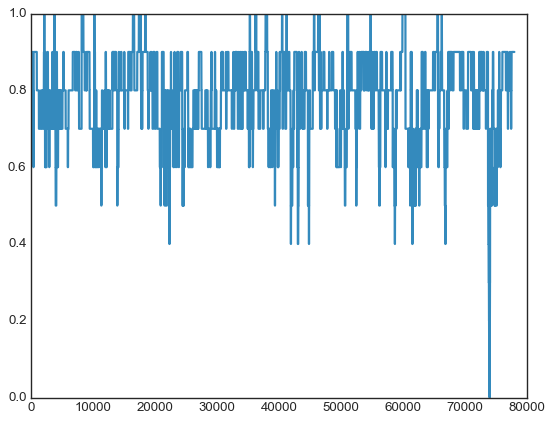

In [147]:
#plt.figure(figsize=(12,8))
plt.plot(Arabesque_predprob[:,1])

#### Mazurkas

In [130]:
Mazurkas_pred = RF.predict(prepare_for_test(learning_Mazurkas))
Mazurkas_predprob = RF.predict_proba(prepare_for_test(learning_Mazurkas))

print(f'Pred: {Mazurkas_pred.mean()}')
print(f'Pred Prob: {Mazurkas_predprob[:,1].mean()}')

Pred: 0.6780830083280821
Pred Prob: 0.6242451078903895


<b><u>Results:</u></b> These were strictly sight read, with no prior playing experience.  Given my sight reading abilities, this seems like a reasonable score.  

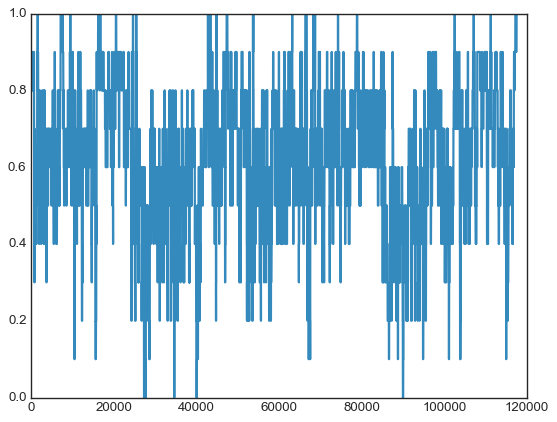

In [148]:
#plt.figure(figsize=(12,8))
plt.plot(Mazurkas_predprob[:,1])

#### Hedwig

In [132]:
Hedwig_pred = RF.predict(prepare_for_test(learned_Hedwig))
Hedwig_predprob = RF.predict_proba(prepare_for_test(learned_Hedwig))

print(f'Pred: {Hedwig_pred.mean()}')
print(f'Pred Prob: {Hedwig_predprob[:,1].mean()}')

Pred: 0.986698766175143
Pred Prob: 0.7931146554318387


<b><u>Results:</u></b> This data was added to the train/test split, so the success may be influenced by data leakage. However, this was a children's version of the Harry Potter theme song, and was not difficult for me to have learned it.

#### Nocturne

In [134]:
Noct_pred = RF.predict(prepare_for_test(learning_Nocturne))
Noct_predprob = RF.predict_proba(prepare_for_test(learning_Nocturne))

print(f'Pred: {Noct_pred.mean()}')
print(f'Pred Prob: {Noct_predprob[:,1].mean()}')

Pred: 0.7640726819829637
Pred Prob: 0.6638702933523118


<b><u>Results:</u></b> Chopin's Nocturne in Eb, is one that is a true "test" case.  No data was leaked into the train/val split, and the results are about what I would expect for my abilities on this piece.

### Consecutive Performance Test

In [757]:
take_1 = pd.read_csv('./data/eeg/Learn_No_Learn/museMonitor_2019-08-26--17-41-25.csv')
take_2 = pd.read_csv('./data/eeg/Learn_No_Learn/museMonitor_2019-08-26--18-01-57.csv')
take_3 = pd.read_csv('./data/eeg/Learn_No_Learn/museMonitor_2019-08-26--18-23-35.csv')
take_4 = pd.read_csv('./data/eeg/Learn_No_Learn/museMonitor_2019-08-26--18-24-42.csv')

In [81]:
X_1 = prepare_for_test(take_1)
X_2 = prepare_for_test(take_2)
X_3 = prepare_for_test(take_3) 
X_4 = prepare_for_test(take_4)

In [86]:
def model_predict_mean(model):

    X_1_pred = model.predict(X_1)
    X_1_predprob = model.predict_proba(X_1)

    print(f'Attempt 1 Pred: {X_1_pred.mean()}')
    print(f'Attempt 1 Pred Prob: {X_1_predprob[:,1].mean()}')

    X_2_pred = model.predict(X_2)
    X_2_predprob = model.predict_proba(X_2)

    print(f'Attempt 2 Pred: {X_2_pred.mean()}')
    print(f'Attempt 2 Pred Prob: {X_2_predprob[:,1].mean()}')

    X_3_pred = model.predict(X_3)
    X_3_predprob = model.predict_proba(X_3)

    print(f'Attempt 3 Pred: {X_3_pred.mean()}')
    print(f'Attempt 3 Pred Prob: {X_3_predprob[:,1].mean()}')

    X_4_pred = model.predict(X_4)
    X_4_predprob = model.predict_proba(X_4)

    print(f'Attempt 4 Pred: {X_4_pred.mean()}')
    print(f'Attempt 4 Pred Prob: {X_4_predprob[:,1].mean()}')

In [89]:
model_predict_mean(RF)

Attempt 1 Pred: 0.8106840299656934
Attempt 1 Pred Prob: 0.6886718476510536
Attempt 2 Pred: 0.5621713798493676
Attempt 2 Pred Prob: 0.5731135427028563
Attempt 3 Pred: 0.9855658656515187
Attempt 3 Pred Prob: 0.7369101435482592
Attempt 4 Pred: 0.9319371727748691
Attempt 4 Pred Prob: 0.7499277847987001


#### Results:

There is some success here (the first two Attempts were added to the train/val split, so there is still of room for overfitting here.  The other concern, after observing how the Gamma waves take upwards of 3 or 4 minutes of continuous effort to separate, that these samples weren't quite long enough to be predictive.  

### Conclusion:

I believe I have successfully been able to isolate performances of "Learned" music from those that are not yet learned.  The visualizations above clearly illustrate separation of gamma frequencies on the AF7 channel of the Muse headband.  However, there are limits to this study.  First, the predictions over an entire piece become more accurate with more data.  The final test (consecutive performances), were short 1 minute clips.  In the line graph above, it took almost 4 minutes of "Learned" playing before gamma waves diverged from that of corresponding "Learning" data set.  

In addition, while the is over 1.5 million rows of data, much of it is correlated to itself.  There are only a dozen or so unique performances included in the training/validation and test sets.  As more data is included in training/validation it will be interesting to see how the performance of the model begins to change.  